In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import cv2
import pickle
import glob
from sklearn.cluster import KMeans
import tqdm as tqdm
%matplotlib inline

In [2]:
def undistort(img):
    #Load pickle
    dist_pickle = pickle.load( open( "calibration_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

    # Undistort sample image
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted

## CREATING MASK FOR THE ROAD ##
def mask(img):
    img_mask = np.zeros(img.shape[:2], dtype="uint8")
    #img_mask = np.zeros_like(img)
    lane_shape = np.array([[10, 510], [200, 450], [1070, 450], [1270, 510], [1270, 700], [10, 700]]) 			#Creating a mask for the road
    cv2.fillConvexPoly(img_mask, lane_shape, 255)								#The generated mask will be white
    masked_img = cv2.bitwise_and(img, img, mask = img_mask)
    return masked_img

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobelx)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary

def bounding_box(grad_binary):
    points = [(10, 510), (200, 450), (1070,450), (1270, 510), (1270, 700), (10, 700)]
    cv2.line(grad_binary, points[0], points[1], 0, 5)
    cv2.line(grad_binary, points[1], points[2], 0, 5)
    cv2.line(grad_binary, points[2], points[3], 0, 5)
    cv2.line(grad_binary, points[3], points[4], 0, 5)
    cv2.line(grad_binary, points[4], points[5], 0, 5)
    cv2.line(grad_binary, points[5], points[0], 0, 5)
    return grad_binary

def perspective_transform(img, mtx, dist, isColor=True):
    # Use the OpenCV undistort() function to remove distortion
    #undist = cv2.undistort(img, mtx, dist, None, mtx)
    '''
    if(isColor):
        # Convert undistorted image to grayscale
        gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    else:
        gray = undist
    '''
    xoffset = 0 # offset for dst points
    yoffset = 0
    img_size = (img.shape[1], img.shape[0])
    #img_size = (undist.shape[1], undist.shape[0])

    src = np.float32([[(10, 450), (1250,450), (1250, 700), (10, 700)]])
    #src = np.float32([(500, 450), (830,450), (1200, 700), (140, 700)])
    dst = np.float32([[xoffset, yoffset], [img_size[0]-xoffset, yoffset], 
                                 [img_size[0]-xoffset, img_size[1]-yoffset], 
                                 [xoffset, img_size[1]-yoffset]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M

#Load pickle
dist_pickle = pickle.load( open( "calibration_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

In [3]:
def plot_images(original, modified, title):
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(original)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(modified, cmap='gray')
    ax2.set_title(title, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

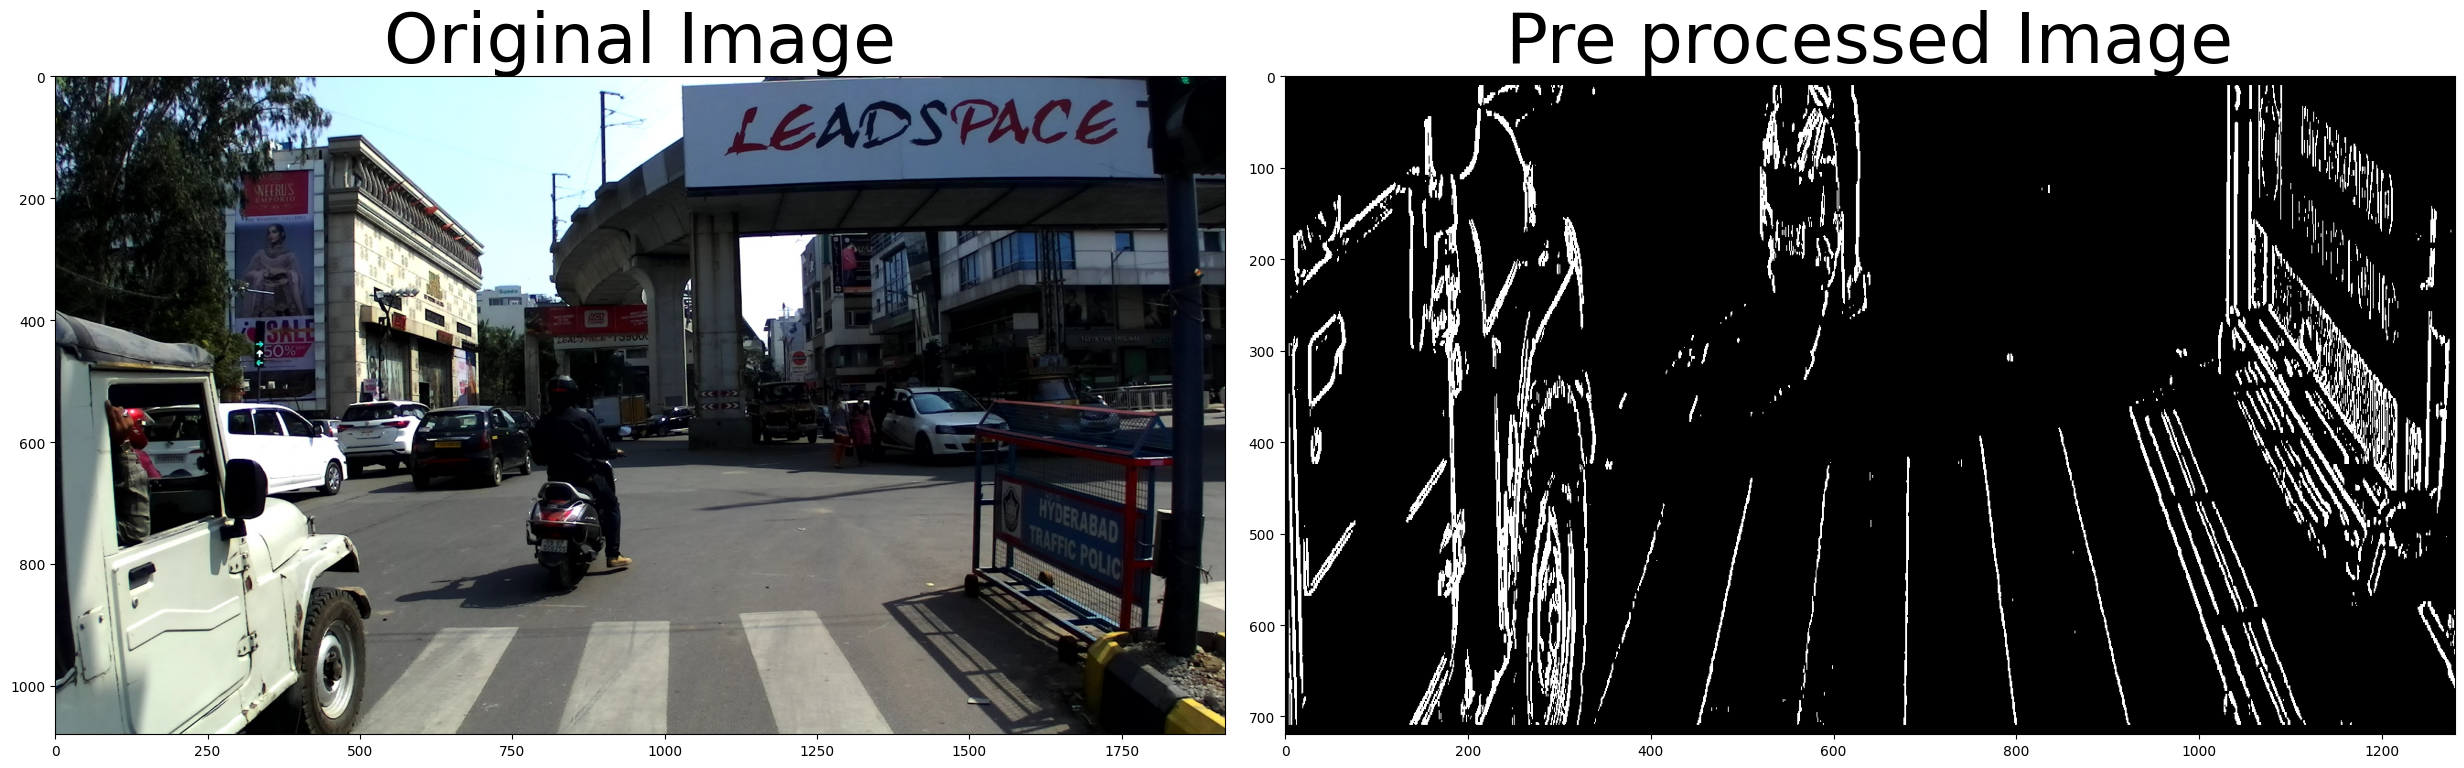

In [4]:
def preprocessing(img):
    undistorted_image = undistort(img)
    masked_image = mask(undistorted_image)
    sobel_thresholded_image = abs_sobel_thresh(masked_image, orient='x', sobel_kernel=3, thresh=(21,255))
    bounded_image = bounding_box(sobel_thresholded_image)
    dist_pickle = pickle.load( open( "calibration_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    transform, M = perspective_transform(bounded_image, mtx, dist)
    return transform

image = 'D:/Academic stuff/MSIS Github/Mini-project-data/Dataset/Structured/frame0000_leftImg8bit.jpg'
testing = mpimg.imread(image)
testing = cv2.resize(testing, (1280, 720))
preprocessed = preprocessing(testing)
plot_images(mpimg.imread(image), preprocessed, "Pre processed Image")

In [5]:
structured = 834
unstructured = 917
count = 0
source1 = 'C:/Users/adshi/Downloads/Validation'
source2 = 'D:/Academic stuff/MSIS Github/Mini-project-data/Dataset/Unstructured'
destination1 = 'D:/Academic stuff/MSIS Github/Mini-project-data/Dataset/Val_dataset'
destination2 = 'D:/Academic stuff/MSIS Github/Mini-project-data/Dataset/Unstructured preprocessed'
current = 'D:/Academic stuff/MSIS Github/Road-detection'
i=0

## To be run only once

In [7]:
for image in os.listdir(source1):
    filename = source1 + '/{}'.format(image)
    img = mpimg.imread(filename)
    img = cv2.resize(img, (1280, 720))
    preprocessed_image = preprocessing(img)
    i +=1
    os.chdir(destination1)
    frame_normed = 255 * (preprocessed_image - preprocessed_image.min()) / (preprocessed_image.max() - preprocessed_image.min())
    preprocessed_image = np.array(frame_normed, np.int)
    cv2.imwrite(filename, preprocessed_image)
    os.chdir(current)

C:\Users\adshi\AppData\Local\Temp\ipykernel_18212\482014179.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  preprocessed_image = np.array(frame_normed, np.int)


In [11]:
'''
i=1
for filename in os.listdir(source2):
    new_name = destination2 + '/usimg{}.jpg'.format(i)
    old_name = destination2 + '/img{}.jpg'.format(i)
    i += 1
    os.rename(old_name, new_name)
'''

In [17]:
import pandas as pd
train_df = pd.read_csv('D:/Academic stuff/MSIS Github/Mini-project-data/Dataset/combined.csv')

unstructured    917
structured      834
Name: label, dtype: int64

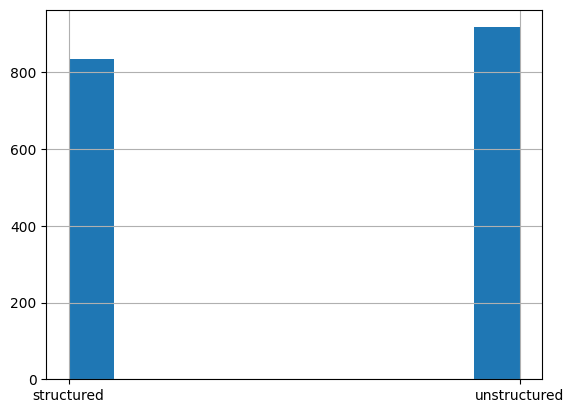

In [18]:
train_df['label'].hist()
train_df['label'].value_counts()

In [22]:
from sklearn.utils import shuffle
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import tensorflow as tf
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
train_df = shuffle(train_df)

In [20]:
train, validate = train_test_split(train_df, test_size = 0.2, random_state = 50)
train = train.reset_index(drop = True)
validate = validate.reset_index(drop = True)

total_train = train.shape[0]
total_validate = validate.shape[0]
batch_size = 15

In [32]:
train_datagen = ImageDataGenerator(rescale= 1./255)
train_generator = train_datagen.flow_from_dataframe(train,
                                                    "D:/Academic stuff/MSIS Github/Mini-project-data/Dataset/Combined/",
                                                    x_col='img_name', 
                                                    y_col = 'label',
                                                    target_size=(720, 404),
                                                    class_mode='categorical',
                                                    batch_size=batch_size)
valid_datagen = ImageDataGenerator(rescale= 1./255)
valid_generator = valid_datagen.flow_from_dataframe(validate,
                                                    "D:/Academic stuff/MSIS Github/Mini-project-data/Dataset/Combined/",
                                                    x_col='img_name', 
                                                    y_col = 'label',
                                                    target_size=(720, 404),
                                                    class_mode='categorical',
                                                    batch_size=batch_size)

Found 1400 validated image filenames belonging to 2 classes.
Found 351 validated image filenames belonging to 2 classes.


In [34]:
model=Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(720, 404, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3,3), activation= 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 718, 402, 16)      448       
                                                                 
 batch_normalization_16 (Bat  (None, 718, 402, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 359, 201, 16)     0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 359, 201, 16)      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 357, 199, 32)      4640      
                                                                 
 batch_normalization_17 (Bat  (None, 357, 199, 32)    

In [37]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [38]:
epochs=10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

C:\Users\adshi\AppData\Local\Temp\ipykernel_8552\3398656332.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
41/93 [============>.................] - ETA: 2:22 - loss: 1.0229 - accuracy: 0.6612

KeyboardInterrupt: 